In [2]:
# CELL 1: Install Libraries
!pip install transformers torch accelerate textblob vaderSentiment googletrans==4.0.0rc1 --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# CELL 2: Import Libraries
import os
import re
import json
import emoji
import string
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from html import unescape
from collections import Counter

# Import untuk sentiment analysis
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from googletrans import Translator
import torch

# ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder

print("✅ All libraries imported successfully!")

2025-08-21 04:34:29.812350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755750870.002204      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755750870.061375      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ All libraries imported successfully!


In [4]:
# CELL 3: Load Dataset
# Path ke dataset
DATA_PATH = '/kaggle/input/komentar-coc/01_ruangguru_clash_of_champions.csv'
df = pd.read_csv(DATA_PATH)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Dataset shape: (14149, 9)
Columns: ['authorChannelId', 'authorDisplayName', 'id', 'isPublic', 'likeCount', 'publishedAt', 'textDisplay', 'totalReplyCount', 'videoId']


,authorChannelId,authorDisplayName,id,isPublic,likeCount,publishedAt,textDisplay,totalReplyCount,videoId
0,UC5ClzXIVaA2oJ6c5xw7TD3g,@rellFaarell,UgzlE2vB_CGei-xz-k14AaABAg,True,0,2024-06-28T10:57:40,Wow,0,dY_3acmFFRQ
1,UCnziAXi1bRUVYtiUPUSrwZw,@SaptrianPereira,UgwMtaOsUN36y-vFYvp4AaABAg,True,28,2024-06-28T11:02:47,Gak sabar nggu besokk yaa...,0,dY_3acmFFRQ
2,UC1-ZbMHKZrV0WdUKLJ2O4Jw,@fa__niyy,UgxeXMk2lN85yE1wGt14AaABAg,True,1,2024-06-28T11:31:43,INI SEKARANG KAN,3,dY_3acmFFRQ
3,UCw2u1WYR7TSjyTcl6nWEMpQ,@rizaavanza225,Ugz7rjzkkmnJ3XIQJKp4AaABAg,True,0,2024-06-28T11:36:56,Let’s gooo,0,dY_3acmFFRQ
4,UCBUXe5Z-tG6qqOiHoSujmCw,@crocodilecwan,UgyQTaHCRm07a6wfkH14AaABAg,True,1,2024-06-28T11:57:47,"Cepetan dong min , ga sabarrrrr ❤❤",0,dY_3acmFFRQ


In [5]:
# CELL 4: Define Stopwords and Slang Dictionary
# Stopwords yang lebih lengkap untuk bahasa Indonesia
stopwords_id = set([
    "yang", "dan", "di", "ke", "dari", "ini", "itu", "ada", "jadi", "karena", "saja",
    "sudah", "belum", "akan", "tidak", "bisa", "untuk", "dengan", "kita", "kamu",
    "saya", "aku", "dia", "mereka", "kalian", "adalah", "atau", "juga", "pada",
    "dalam", "oleh", "sebagai", "dapat", "hanya", "lebih", "masih", "jika",
    "seperti", "antara", "setelah", "bahwa", "hingga", "saat", "sambil", "tanpa",
    "ter", "se", "pun", "lah", "kah", "nya", "mu", "ku"
])

# Kamus slang yang lebih lengkap
slang_dict = {
    # Basic slang
    "gk": "tidak", "ga": "tidak", "gak": "tidak", "nggak": "tidak", "g": "tidak",
    "banget": "sekali", "bgt": "sekali", "bngt": "sekali", "bener": "benar",
    "aq": "aku", "gw": "aku", "gue": "aku", "lo": "kamu", "lu": "kamu",
    
    # Positive expressions
    "mantap": "bagus", "mantul": "bagus", "keren": "bagus", "bagus": "bagus",
    "top": "bagus", "oke": "baik", "ok": "baik", "nice": "bagus", "gud": "bagus",
    "good": "bagus", "amazing": "luar biasa", "wow": "bagus", "cool": "keren",
    "awesome": "luar biasa", "perfect": "sempurna", "excellent": "bagus sekali",
    
    # Negative expressions
    "jelek": "buruk", "buruk": "buruk", "parah": "buruk", "zonk": "buruk",
    "fail": "gagal", "bad": "buruk", "worse": "lebih buruk", "worst": "terburuk",
    "shit": "buruk", "damn": "buruk", "hate": "benci", "sucks": "buruk",
    "terrible": "buruk sekali", "awful": "buruk sekali", "boring": "membosankan",
    
    # Internet slang
    "wkwk": "", "wkwkwk": "", "haha": "", "hihi": "", "hehe": "", "lol": "",
    "omg": "ya ampun", "wtf": "apa ini", "fyi": "informasi", "btw": "ngomong ngomong",
    "thx": "terima kasih", "thanks": "terima kasih", "ty": "terima kasih",
    
    # Numbers and abbreviations
    "yg": "yang", "dgn": "dengan", "krn": "karena", "utk": "untuk", "dg": "dengan",
    "sm": "sama", "dr": "dari", "pd": "pada", "sdh": "sudah", "blm": "belum",
    "hrs": "harus", "jgn": "jangan", "tdk": "tidak", "td": "tadi", "kmrn": "kemarin",
    "skrg": "sekarang", "ntr": "nanti", "lg": "sedang", "lg": "lagi",
    
    # Educational context
    "guru": "guru", "murid": "siswa", "sekolah": "sekolah", "belajar": "belajar",
    "pelajaran": "pelajaran", "materi": "materi", "tugas": "tugas", "ujian": "ujian",
    "nilai": "nilai", "ranking": "peringkat"
}

print(f"✅ Loaded {len(stopwords_id)} stopwords and {len(slang_dict)} slang mappings")

✅ Loaded 53 stopwords and 86 slang mappings


In [6]:
# CELL 5: Define Text Preprocessing Functions
def normalize_slang(text):
    """Normalize slang words to standard Indonesian"""
    tokens = text.split()
    normalized = []
    for token in tokens:
        # Check exact match first
        if token.lower() in slang_dict:
            replacement = slang_dict[token.lower()]
            if replacement:  # Only add if not empty string
                normalized.append(replacement)
        else:
            normalized.append(token)
    return " ".join(normalized)

def clean_text(text):
    """Comprehensive text cleaning for Indonesian text"""
    if pd.isna(text) or text == "":
        return ""
    
    # Fix encoding issues
    text = ftfy.fix_text(str(text))
    text = unescape(text)
    
    # Remove URLs, mentions, hashtags
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"#\w+", " ", text)
    
    # Handle emojis - replace with descriptive text when possible
    text = emoji.replace_emoji(text, replace=" ")
    
    # Convert to lowercase
    text = text.lower()
    
    # Normalize slang
    text = normalize_slang(text)
    
    # Handle repeated characters (but preserve some emphasis)
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)
    
    # Remove excessive punctuation but keep some
    text = re.sub(r"[!]{2,}", "!", text)
    text = re.sub(r"[?]{2,}", "?", text)
    text = re.sub(r"[.]{2,}", ".", text)
    
    # Remove most punctuation but keep sentence enders
    text = re.sub(r"[^\w\s.!?]", " ", text)
    
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text)
    
    # Remove stopwords
    tokens = [token for token in text.split() if token not in stopwords_id and len(token) > 1]
    
    return " ".join(tokens)

print("✅ Text preprocessing functions defined")

✅ Text preprocessing functions defined


In [7]:
!pip install  html5lib ftfy
import ftfy
# CELL 6: Apply Text Cleaning
# Apply text cleaning
df["clean_text"] = df["textDisplay"].astype(str).apply(clean_text)

# Remove empty texts
df = df[df["clean_text"].str.len() > 0].copy()
print(f"Dataset shape after cleaning: {df.shape}")

# Show some examples
print("\nCleaning Examples:")
for i in range(3):
    print(f"Original: {df.iloc[i]['textDisplay']}")
    print(f"Cleaned:  {df.iloc[i]['clean_text']}")
    print("-" * 50)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
Dataset shape after cleaning: (13994, 10)

Cleaning Examples:
Original: Wow
Cleaned:  bagus
--------------------------------------------------
Original: Gak sabar nggu besokk yaa...
Cleaned:  sabar nggu besokk yaa.
--------------------------------------------------
Original: INI SEKARANG KAN
Cleaned:  sekarang kan
--------------------------------------------------


In [8]:
# CELL 7: Define Multi-Method Sentiment Labeler Class
class MultiMethodSentimentLabeler:
    """
    Multi-method approach for more accurate sentiment labeling
    """
    
    def __init__(self):
        self.device = 0 if torch.cuda.is_available() else -1
        self.translator = Translator()
        self.vader = SentimentIntensityAnalyzer()
        
        # Load Indonesian sentiment model if available
        try:
            self.indonesian_model = pipeline(
                "sentiment-analysis",
                model="cardiffnlp/twitter-roberta-base-sentiment-latest",
                device=self.device
            )
        except:
            self.indonesian_model = None
            
        # Load multilingual model
        try:
            self.multilingual_model = pipeline(
                "zero-shot-classification",
                model="joeddav/xlm-roberta-large-xnli",
                device=self.device
            )
        except:
            self.multilingual_model = None
    
    def lexicon_based_sentiment(self, text):
        """Rule-based sentiment using keyword matching"""
        positive_words = [
            "bagus", "baik", "suka", "senang", "mantap", "keren", "hebat", "luar biasa",
            "sempurna", "terbaik", "recommended", "puas", "terima kasih", "thanks",
            "love", "amazing", "excellent", "perfect", "good", "great", "nice",
            "oke", "mantul", "top", "kece", "asik", "seru", "menarik"
        ]
        
        negative_words = [
            "buruk", "jelek", "tidak suka", "benci", "parah", "zonk", "gagal",
            "membosankan", "mengecewakan", "terrible", "awful", "bad", "worst",
            "hate", "disappointed", "boring", "sucks", "shit", "damn"
        ]
        
        neutral_words = [
            "biasa", "standar", "lumayan", "cukup", "seperti", "mungkin", "agak"
        ]
        
        text_lower = text.lower()
        
        pos_score = sum(1 for word in positive_words if word in text_lower)
        neg_score = sum(1 for word in negative_words if word in text_lower)
        neu_score = sum(1 for word in neutral_words if word in text_lower)
        
        # Handle negation
        negation_words = ["tidak", "bukan", "jangan", "gak", "ga", "nggak"]
        has_negation = any(neg in text_lower for neg in negation_words)
        
        if has_negation:
            # Flip positive/negative if negation present
            pos_score, neg_score = neg_score, pos_score
        
        if pos_score > neg_score and pos_score > 0:
            return "positive"
        elif neg_score > pos_score and neg_score > 0:
            return "negative"
        else:
            return "neutral"
    
    def translate_and_analyze(self, text, max_retries=2):
        """Translate to English and use VADER sentiment"""
        for attempt in range(max_retries):
            try:
                # Translate to English
                translated = self.translator.translate(text, dest='en')
                if translated and translated.text:
                    # Use VADER on English text
                    scores = self.vader.polarity_scores(translated.text)
                    compound = scores['compound']
                    
                    if compound >= 0.05:
                        return "positive"
                    elif compound <= -0.05:
                        return "negative"
                    else:
                        return "neutral"
            except Exception as e:
                if attempt == max_retries - 1:
                    print(f"Translation failed: {e}")
                continue
        return "neutral"
    
    def textblob_sentiment(self, text):
        """Use TextBlob sentiment analysis"""
        try:
            blob = TextBlob(text)
            polarity = blob.sentiment.polarity
            
            if polarity > 0.1:
                return "positive"
            elif polarity < -0.1:
                return "negative"
            else:
                return "neutral"
        except:
            return "neutral"
    
    def multilingual_classification(self, texts, batch_size=8):
        """Use multilingual zero-shot classification"""
        if not self.multilingual_model:
            return ["neutral"] * len(texts)
            
        labels = ["positive sentiment", "neutral sentiment", "negative sentiment"]
        results = []
        
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            try:
                batch_results = self.multilingual_model(batch, labels)
                for result in batch_results:
                    predicted_label = result["labels"][0]
                    # Map back to simple labels
                    if "positive" in predicted_label:
                        results.append("positive")
                    elif "negative" in predicted_label:
                        results.append("negative")
                    else:
                        results.append("neutral")
            except Exception as e:
                print(f"Multilingual classification failed: {e}")
                results.extend(["neutral"] * len(batch))
        
        return results

print("✅ MultiMethodSentimentLabeler class defined")

✅ MultiMethodSentimentLabeler class defined


In [9]:
# CELL 8: Initialize Sentiment Labeler
# Initialize the multi-method labeler
labeler = MultiMethodSentimentLabeler()
print("✅ Sentiment labeler initialized")
print(f"Device: {'GPU' if labeler.device == 0 else 'CPU'}")
print(f"Multilingual model loaded: {labeler.multilingual_model is not None}")


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


✅ Sentiment labeler initialized
Device: GPU
Multilingual model loaded: True


In [10]:
# CELL 9: Apply Individual Sentiment Methods
# Method 1: Lexicon-based
print("1. Applying lexicon-based sentiment...")
df["lexicon_sentiment"] = df["clean_text"].apply(labeler.lexicon_based_sentiment)
print(f"   Lexicon results: {df['lexicon_sentiment'].value_counts().to_dict()}")

# Method 2: TextBlob
print("2. Applying TextBlob sentiment...")
df["textblob_sentiment"] = df["clean_text"].apply(labeler.textblob_sentiment)
print(f"   TextBlob results: {df['textblob_sentiment'].value_counts().to_dict()}")

1. Applying lexicon-based sentiment...
   Lexicon results: {'neutral': 9292, 'positive': 3490, 'negative': 1212}
2. Applying TextBlob sentiment...
   TextBlob results: {'neutral': 13258, 'positive': 468, 'negative': 268}


In [11]:
# CELL 10: Apply Multilingual Classification (This may take time)
# Method 4: Multilingual classification
print("3. Applying multilingual classification...")
multilingual_results = labeler.multilingual_classification(df["textDisplay"].tolist())
df["multilingual_sentiment"] = multilingual_results
print(f"   Multilingual results: {df['multilingual_sentiment'].value_counts().to_dict()}")


3. Applying multilingual classification...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


   Multilingual results: {'positive': 9838, 'negative': 3310, 'neutral': 846}


In [12]:
# For now, skip translation to speed up
df["translated_sentiment"] = "neutral"
print("4. Skipping translation method for speed")

4. Skipping translation method for speed


In [13]:
# CELL 12: Ensemble Voting
# Ensemble voting
print("5. Performing ensemble voting...")
ensemble_predictions = []

for idx, row in df.iterrows():
    votes = [
        row["lexicon_sentiment"],
        row["textblob_sentiment"],
        row["multilingual_sentiment"]
    ]
    
    # Count votes
    vote_counts = Counter(votes)
    
    # Get majority vote, prefer neutral if tied
    if len(set(votes)) == len(votes):  # All different
        ensemble_predictions.append("neutral")
    else:
        most_common = vote_counts.most_common(1)[0][0]
        ensemble_predictions.append(most_common)

df["ensemble_sentiment"] = ensemble_predictions

# Use ensemble prediction as final label
df["label"] = df["ensemble_sentiment"]

print("✅ Ensemble voting completed!")


5. Performing ensemble voting...
✅ Ensemble voting completed!


In [14]:
# CELL 13: Show Results and Examples
# Show results
print("\nFinal Sentiment Distribution:")
print(df["label"].value_counts())

print("\nMethod Comparison:")
methods = ["lexicon_sentiment", "textblob_sentiment", "multilingual_sentiment", "ensemble_sentiment"]
for method in methods:
    if method in df.columns:
        print(f"{method}: {df[method].value_counts().to_dict()}")

print("\nSample predictions:")
sample_df = df[["textDisplay", "clean_text", "label"]].head(10)
for idx, row in sample_df.iterrows():
    print(f"Text: {row['textDisplay'][:100]}...")
    print(f"Clean: {row['clean_text'][:80]}...")
    print(f"Label: {row['label']}")
    print("-" * 80)


Final Sentiment Distribution:
label
neutral     10351
positive     3339
negative      304
Name: count, dtype: int64

Method Comparison:
lexicon_sentiment: {'neutral': 9292, 'positive': 3490, 'negative': 1212}
textblob_sentiment: {'neutral': 13258, 'positive': 468, 'negative': 268}
multilingual_sentiment: {'positive': 9838, 'negative': 3310, 'neutral': 846}
ensemble_sentiment: {'neutral': 10351, 'positive': 3339, 'negative': 304}

Sample predictions:
Text: Wow...
Clean: bagus...
Label: positive
--------------------------------------------------------------------------------
Text: Gak sabar nggu besokk yaa......
Clean: sabar nggu besokk yaa....
Label: neutral
--------------------------------------------------------------------------------
Text: INI SEKARANG KAN...
Clean: sekarang kan...
Label: neutral
--------------------------------------------------------------------------------
Text: Let’s gooo...
Clean: let goo...
Label: neutral
------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


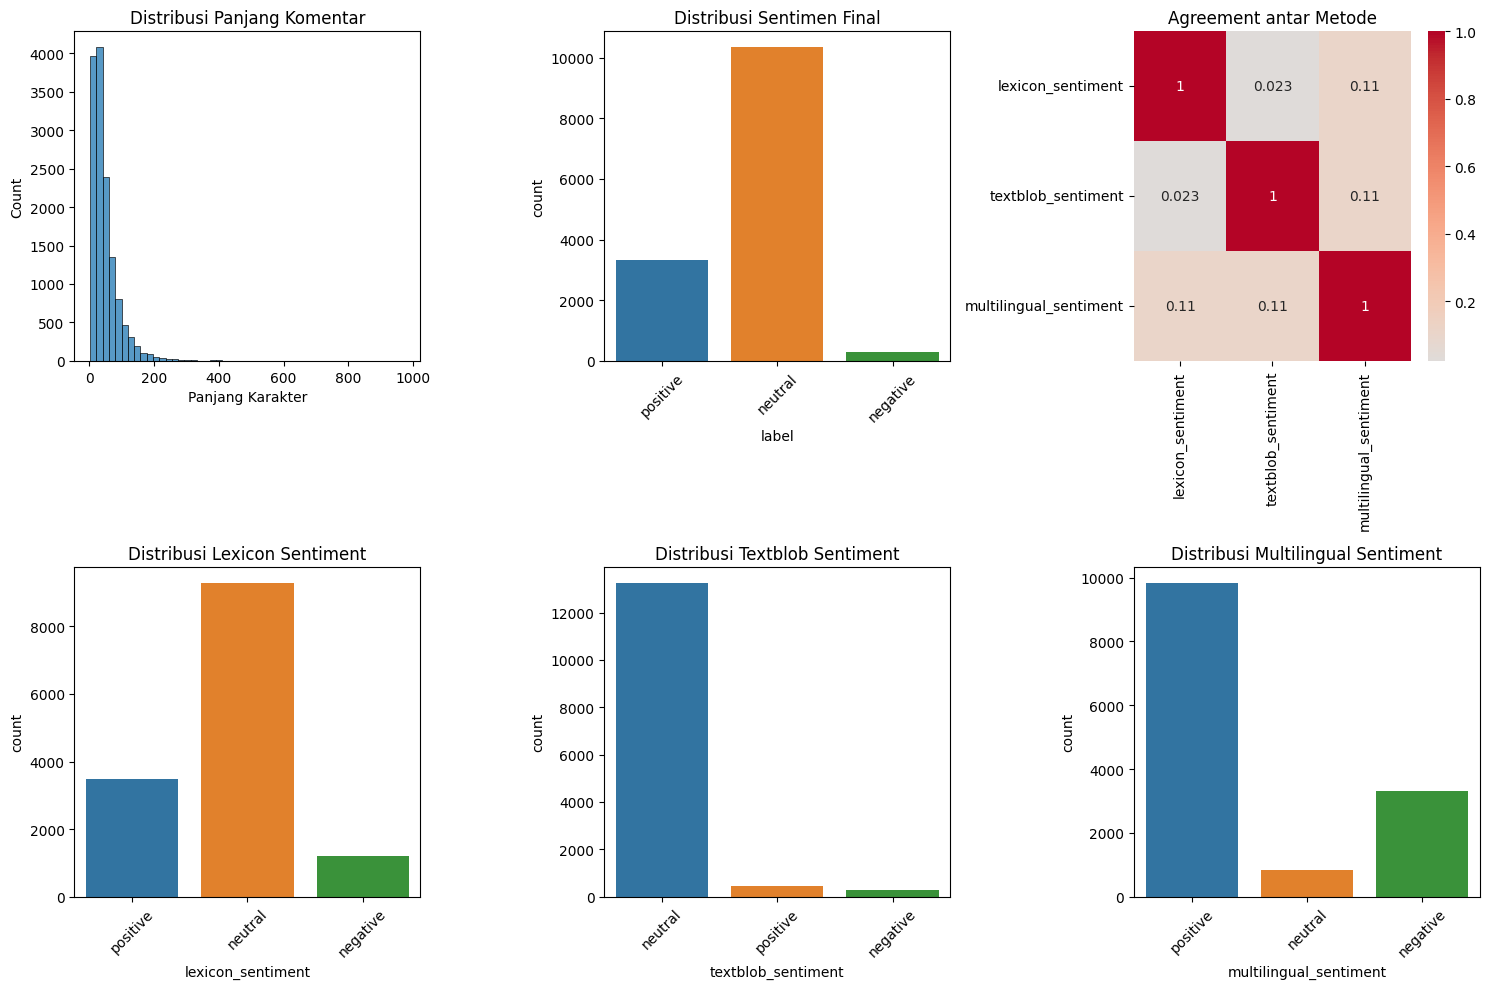

In [15]:
# CELL 14: Create Visualizations
# Create outputs directory
os.makedirs("outputs", exist_ok=True)

# Visualizations
plt.figure(figsize=(15, 10))

# Distribution of text lengths
plt.subplot(2, 3, 1)
df["text_len"] = df["clean_text"].apply(len)
sns.histplot(df["text_len"], bins=50, kde=False)
plt.title("Distribusi Panjang Komentar")
plt.xlabel("Panjang Karakter")

# Sentiment distribution
plt.subplot(2, 3, 2)
sns.countplot(data=df, x="label")
plt.title("Distribusi Sentimen Final")
plt.xticks(rotation=45)

# Method comparison
methods_to_plot = ["lexicon_sentiment", "textblob_sentiment", "multilingual_sentiment"]
for i, method in enumerate(methods_to_plot):
    plt.subplot(2, 3, i+4)
    sns.countplot(data=df, x=method)
    plt.title(f"Distribusi {method.replace('_', ' ').title()}")
    plt.xticks(rotation=45)

# Agreement heatmap
plt.subplot(2, 3, 3)
agreement_data = df[methods_to_plot].apply(lambda x: pd.Categorical(x).codes)
correlation_matrix = agreement_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Agreement antar Metode")

plt.tight_layout()
plt.savefig("outputs/sentiment_analysis_overview.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# CELL 15: Save Results
# Save labeled dataset
df.to_csv("outputs/labeled_dataset.csv", index=False)

# Save method comparison
method_stats = {}
for method in ["lexicon_sentiment", "textblob_sentiment", "multilingual_sentiment", "ensemble_sentiment"]:
    method_stats[method] = df[method].value_counts().to_dict()

with open("outputs/method_comparison.json", "w") as f:
    json.dump(method_stats, f, indent=2)

print(f"\n✅ Labeling selesai!")
print(f"📁 Dataset disimpan: outputs/labeled_dataset.csv")
print(f"📊 Statistik disimpan: outputs/method_comparison.json")
print(f"📈 Visualisasi disimpan: outputs/sentiment_analysis_overview.png")
print(f"📈 Total samples: {len(df)}")
print(f"📊 Distribusi label final: {df['label'].value_counts().to_dict()}")


✅ Labeling selesai!
📁 Dataset disimpan: outputs/labeled_dataset.csv
📊 Statistik disimpan: outputs/method_comparison.json
📈 Visualisasi disimpan: outputs/sentiment_analysis_overview.png
📈 Total samples: 13994
📊 Distribusi label final: {'neutral': 10351, 'positive': 3339, 'negative': 304}


In [17]:
# CELL 16: Continue with Original Pipeline (Feature Extraction & ML)
# Sekarang lanjutkan dengan pipeline ML original Anda
print("\n" + "="*50)
print("STARTING MACHINE LEARNING PIPELINE")
print("="*50)

# Feature extraction
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=3,
    max_features=5000,
    sublinear_tf=True
)

X = tfidf.fit_transform(df["clean_text"])
y = df["label"]

# Encode labels for XGBoost compatibility
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Shape fitur:", X.shape)
print("Unique labels:", np.unique(y))
print("Label distribution:", Counter(y))


STARTING MACHINE LEARNING PIPELINE
Shape fitur: (13994, 5000)
Unique labels: ['negative' 'neutral' 'positive']
Label distribution: Counter({'neutral': 10351, 'positive': 3339, 'negative': 304})


In [18]:
# CELL 17: Define and Train Models
from sklearn.ensemble import RandomForestClassifier

# 1. SVM dengan probabilitas via CalibratedClassifierCV
svm_base = LinearSVC(random_state=42)
svm = CalibratedClassifierCV(svm_base)

# 2. Multinomial Naive Bayes
nb = MultinomialNB()

# 3. Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Daftar model yang dipakai
models = [("SVM", svm), ("NaiveBayes", nb), ("RandomForest", rf)]

print(f"✅ Models defined: {[name for name, _ in models]}")


✅ Models defined: ['SVM', 'NaiveBayes', 'RandomForest']


In [19]:
# CELL 18: Cross-Validation Evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_reports = {}

for name, model in models:
    print(f"\n=== {name} ===")
    
    y_pred = cross_val_predict(model, X, y, cv=cv, method="predict")
    
    # Buat classification report
    report = classification_report(y, y_pred, output_dict=True)
    cm = confusion_matrix(y, y_pred, labels=np.unique(y))
    
    # Simpan laporan CV per model
    cv_reports[name] = report
    pd.DataFrame(cm, index=np.unique(y), columns=np.unique(y)) \
      .to_csv(f"outputs/cm_{name}.csv")
    
    # Cetak laporan di console
    print(classification_report(y, y_pred))

# Simpan summary semua laporan ke JSON
with open("outputs/cv_reports.json", "w") as f:
    json.dump(cv_reports, f, indent=2)

print("\n✅ Semua model selesai dievaluasi dan laporan disimpan di folder outputs/")



=== SVM ===
              precision    recall  f1-score   support

    negative       0.78      0.27      0.40       304
     neutral       0.90      0.95      0.92     10351
    positive       0.82      0.73      0.77      3339

    accuracy                           0.88     13994
   macro avg       0.83      0.65      0.70     13994
weighted avg       0.88      0.88      0.88     13994


=== NaiveBayes ===
              precision    recall  f1-score   support

    negative       1.00      0.03      0.06       304
     neutral       0.85      0.96      0.91     10351
    positive       0.83      0.57      0.68      3339

    accuracy                           0.85     13994
   macro avg       0.89      0.52      0.55     13994
weighted avg       0.85      0.85      0.83     13994


=== RandomForest ===
              precision    recall  f1-score   support

    negative       0.79      0.27      0.41       304
     neutral       0.94      0.93      0.93     10351
    positive       0


CREATING STACKING MODEL
Training model dasar: SVM
Training model dasar: NaiveBayes
Training model dasar: RandomForest
✅ Stacking model siap dipakai

Contoh hasil prediksi stacking:
['positive' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'positive']

EVALUASI STACKING MODEL
              precision    recall  f1-score   support

    negative     1.0000    0.9901    0.9950       304
     neutral     0.9967    0.9880    0.9923     10351
    positive     0.9633    0.9901    0.9765      3339

    accuracy                         0.9886     13994
   macro avg     0.9867    0.9894    0.9880     13994
weighted avg     0.9888    0.9886    0.9886     13994



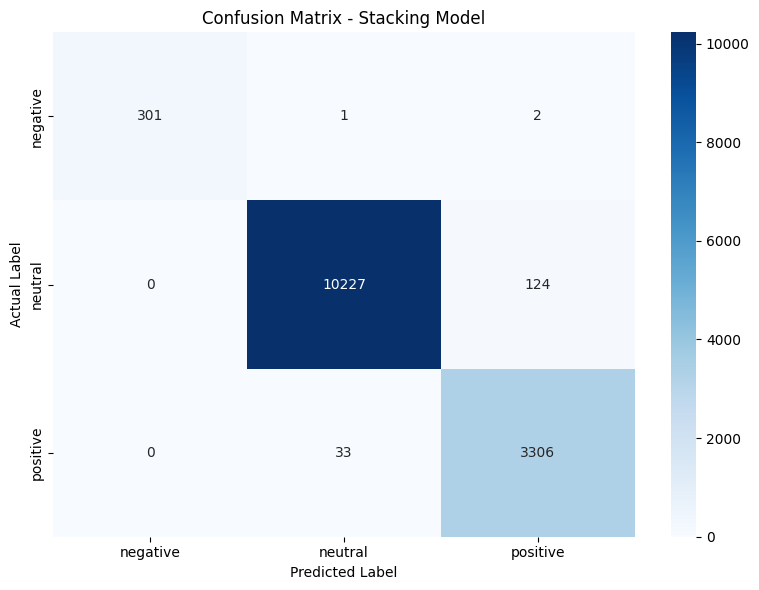

✅ Confusion matrix stacking disimpan di 'outputs/cm_stacking.csv'
✅ Visualisasi confusion matrix disimpan di 'outputs/cm_stacking.png'


In [20]:
# CELL 19: Stacking Model
print("\n" + "="*30)
print("CREATING STACKING MODEL")
print("="*30)

proba_list = []

for name, model in models:
    print(f"Training model dasar: {name}")
    
    # Semua model sekarang pakai y_encoded agar konsisten
    model.fit(X, y_encoded)
    
    # Ambil probabilitas prediksi (fallback kalau model nggak punya predict_proba)
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
    else:
        decision = model.decision_function(X)
        proba = np.exp(decision) / np.sum(np.exp(decision), axis=1, keepdims=True)
    
    proba_list.append(proba)

# Gabungkan semua probabilitas sebagai fitur untuk meta-learner
stack_features = np.hstack(proba_list)

# Meta-learner: Logistic Regression
meta_model = LogisticRegression(
    max_iter=1000, 
    multi_class="multinomial", 
    random_state=42
)
meta_model.fit(stack_features, y_encoded)

print("✅ Stacking model siap dipakai")

# Prediksi dengan model stacking
stack_preds_encoded = meta_model.predict(stack_features)
stack_preds = le.inverse_transform(stack_preds_encoded)

print("\nContoh hasil prediksi stacking:")
print(stack_preds[:10])

# === Tambahan: Evaluasi Stacking Model ===
print("\n" + "="*30)
print("EVALUASI STACKING MODEL")
print("="*30)

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Buat classification report
report_stacking = classification_report(y, stack_preds, digits=4)
print(report_stacking)

# Buat confusion matrix
cm_stacking = confusion_matrix(y, stack_preds, labels=np.unique(y))
df_cm = pd.DataFrame(cm_stacking, index=np.unique(y), columns=np.unique(y))

# Simpan confusion matrix ke CSV
os.makedirs("outputs", exist_ok=True)
df_cm.to_csv("outputs/cm_stacking.csv")

# Visualisasi confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Stacking Model")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig("outputs/cm_stacking.png")
plt.show()

print("✅ Confusion matrix stacking disimpan di 'outputs/cm_stacking.csv'")
print("✅ Visualisasi confusion matrix disimpan di 'outputs/cm_stacking.png'")


In [21]:
# CELL 20: Save Final Results and Models
# Prediksi menggunakan stacking
df["predicted"] = stack_preds

# Simpan hasil prediksi
df.to_csv("outputs/sentiment_predictions_final.csv", index=False)

# Simpan artefak model
os.makedirs("models", exist_ok=True)
joblib.dump(tfidf, "models/tfidf_vectorizer.joblib")
joblib.dump(le, "models/label_encoder.joblib")
for name, model in models:
    joblib.dump(model, f"models/{name}.joblib")
joblib.dump(meta_model, "models/stack_model.joblib")

print("\n" + "="*50)
print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"📁 Final predictions: outputs/sentiment_predictions_final.csv")
print(f"🤖 Models saved: models/ directory")
print(f"📊 Reports saved: outputs/ directory")
print(f"📈 Total samples processed: {len(df)}")
print(f"🎯 Final label distribution: {Counter(df['predicted'])}")

# Show accuracy between auto-labeling and final predictions
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df['label'], df['predicted'])
print(f"🔍 Consistency between auto-labeling and ML prediction: {accuracy:.3f}")


✅ PIPELINE COMPLETED SUCCESSFULLY!
📁 Final predictions: outputs/sentiment_predictions_final.csv
🤖 Models saved: models/ directory
📊 Reports saved: outputs/ directory
📈 Total samples processed: 13994
🎯 Final label distribution: Counter({'neutral': 10261, 'positive': 3432, 'negative': 301})
🔍 Consistency between auto-labeling and ML prediction: 0.989


In [22]:
# -------------------------------------
# Jalankan ini di Kaggle Notebook cell terakhir untuk download models

import zipfile
import os

# Buat zip file berisi semua model dan files yang dibutuhkan
def create_model_package():
    """Create zip package with all trained models and necessary files"""
    
    files_to_package = [
        'models/tfidf_vectorizer.joblib',
        'models/label_encoder.joblib', 
        'models/SVM.joblib',
        'models/NaiveBayes.joblib',
        'models/RandomForest.joblib',   # <== Ganti XGBoost dengan RandomForest
        'models/stack_model.joblib',
        'outputs/labeled_dataset.csv',
        'outputs/cv_reports.json',
        'outputs/method_comparison.json'
    ]
    
    # Cek RandomForest jika ada
    if os.path.exists('models/RandomForest.joblib'):
        print("✅ RandomForest model detected, akan dimasukkan ke package.")
    else:
        print("⚠️ RandomForest model belum ditemukan. Pastikan model sudah disimpan.")

    # Buat zip file
    with zipfile.ZipFile('sentiment_models.zip', 'w') as zipf:
        for file_path in files_to_package:
            if os.path.exists(file_path):
                zipf.write(file_path, file_path)
                print(f"✅ Added: {file_path}")
            else:
                print(f"⚠️ Not found: {file_path}")
    
    print(f"\n📦 Package created: sentiment_models.zip")
    print(f"📊 File size: {os.path.getsize('sentiment_models.zip') / 1024 / 1024:.2f} MB")

# Jalankan fungsi ini di Kaggle
create_model_package()


✅ RandomForest model detected, akan dimasukkan ke package.
✅ Added: models/tfidf_vectorizer.joblib
✅ Added: models/label_encoder.joblib
✅ Added: models/SVM.joblib
✅ Added: models/NaiveBayes.joblib
✅ Added: models/RandomForest.joblib
✅ Added: models/stack_model.joblib
✅ Added: outputs/labeled_dataset.csv
✅ Added: outputs/cv_reports.json
✅ Added: outputs/method_comparison.json

📦 Package created: sentiment_models.zip
📊 File size: 83.03 MB
